In [ ]:
%pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 24.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
%pip install keras

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
import time

In [ ]:
tf.__version__

'2.16.1'

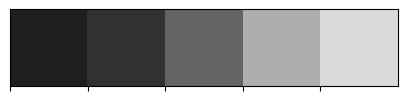

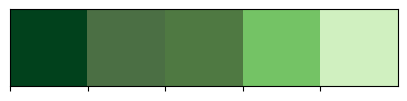

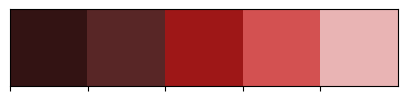

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

#Dataset Preperation

In [ ]:
labels = ['glioma','notumor','meningioma','pituitary']

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Brain-Tumor-Dataset','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Brain-Tumor-Dataset','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:24<00:00,  3.01it/s]


In [ ]:
y_train[1:10]

array(['glioma', 'glioma', 'glioma', 'glioma', 'glioma', 'glioma',
       'glioma', 'glioma', 'glioma'], dtype='<U10')

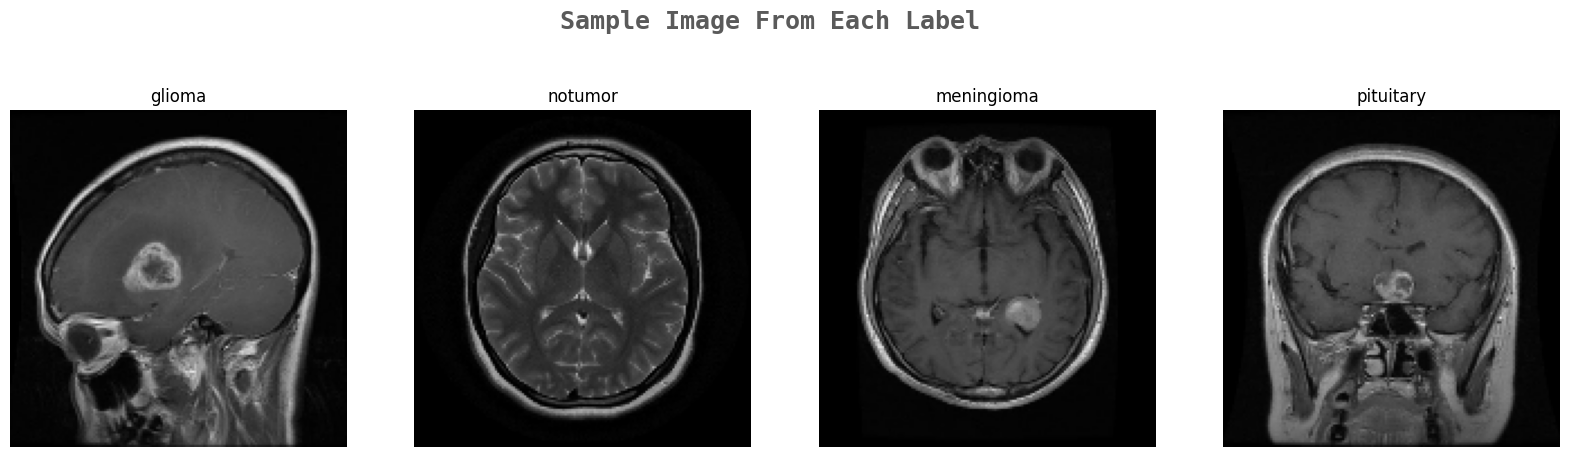

In [ ]:

fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)

for i,name in enumerate(labels):
  for j in range(len(X_train)):
    if y_train[j]==name:
      ax[i].imshow(X_train[j])
      ax[i].set_title(name)
      ax[i].axis("off")
      break

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(3264, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_train[0:1]

array([[1., 0., 0., 0.]])

In [ ]:
X_train.shape

(2937, 150, 150, 3)

In [ ]:
%pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.5 MB/s eta 0:00:00


In [ ]:
from efficientnet.tfkeras import EfficientNetB0

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs=model)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 150, 150, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 150, 150, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 150, 150, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 151, 151, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 75, 75, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 75, 75, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 75, 75, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 75, 75, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 75, 75, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 75, 75, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
tic = time.time()

history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7521 - loss: 0.6159
Epoch 1: val_accuracy improved from -inf to 0.75850, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - accuracy: 0.7530 - loss: 0.6139 - val_accuracy: 0.7585 - val_loss: 1.0853 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9343 - loss: 0.1984
Epoch 2: val_accuracy improved from 0.75850 to 0.87415, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.9343 - loss: 0.1983 - val_accuracy: 0.8741 - val_loss: 0.4314 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9535 - loss: 0.1475
Epoch 3: val_accuracy improved from 0.87415 to 0.95238, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 378s 4s/step - accuracy: 0.9534 - loss: 0.1475 - val_accuracy: 0.9524 - val_loss: 0.1738 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9751 - loss: 0.0

In [ ]:
model.evaluate(X_test,y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 914ms/step - accuracy: 0.9836 - loss: 0.0945


[0.06888370960950851, 0.9847095012664795]

In [ ]:
pred=model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


In [ ]:
pred[0]

array([2.9832943e-09, 9.5758435e-10, 1.3807287e-10, 9.9999994e-01],
      dtype=float32)

In [ ]:
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
pred

array([3, 2, 0, 1, 3, 2, 2, 3, 2, 2, 2, 0, 0, 1, 2, 3, 3, 2, 3, 2, 3, 0,
       1, 1, 1, 3, 0, 3, 3, 2, 2, 3, 0, 2, 3, 2, 3, 2, 0, 2, 0, 2, 3, 2,
       2, 3, 0, 2, 3, 0, 2, 0, 3, 3, 2, 3, 0, 3, 1, 0, 2, 2, 1, 0, 3, 3,
       3, 0, 2, 0, 0, 0, 3, 1, 0, 2, 0, 0, 0, 1, 2, 2, 3, 3, 0, 0, 2, 2,
       2, 1, 1, 3, 2, 2, 0, 2, 0, 2, 3, 2, 2, 0, 2, 2, 1, 3, 3, 0, 0, 2,
       1, 2, 3, 0, 3, 0, 3, 3, 2, 1, 0, 1, 3, 0, 3, 3, 1, 3, 3, 0, 1, 0,
       1, 3, 2, 0, 2, 3, 2, 2, 1, 2, 2, 0, 2, 1, 0, 2, 2, 2, 3, 1, 2, 3,
       2, 3, 1, 1, 2, 0, 3, 2, 1, 2, 0, 2, 0, 1, 0, 0, 2, 3, 3, 1, 2, 1,
       0, 0, 3, 0, 3, 0, 1, 0, 3, 2, 2, 1, 2, 1, 2, 1, 0, 2, 2, 2, 1, 1,
       2, 2, 3, 0, 3, 2, 2, 3, 2, 1, 1, 2, 2, 2, 2, 0, 0, 3, 0, 0, 3, 0,
       2, 1, 3, 1, 3, 0, 1, 1, 3, 2, 0, 0, 3, 0, 0, 2, 3, 3, 0, 0, 3, 0,
       2, 2, 0, 0, 2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 3, 3, 0, 3, 3, 1,
       0, 0, 0, 1, 2, 0, 0, 3, 3, 3, 0, 3, 2, 1, 0, 1, 2, 1, 3, 3, 1, 2,
       0, 1, 1, 0, 2, 0, 2, 3, 3, 2, 3, 0, 0, 3, 0,

In [ ]:
y_test

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        93
           1       1.00      1.00      1.00        51
           2       0.97      0.98      0.97        96
           3       1.00      0.99      0.99        87

    accuracy                           0.98       327
   macro avg       0.99      0.99      0.99       327
weighted avg       0.98      0.98      0.98       327



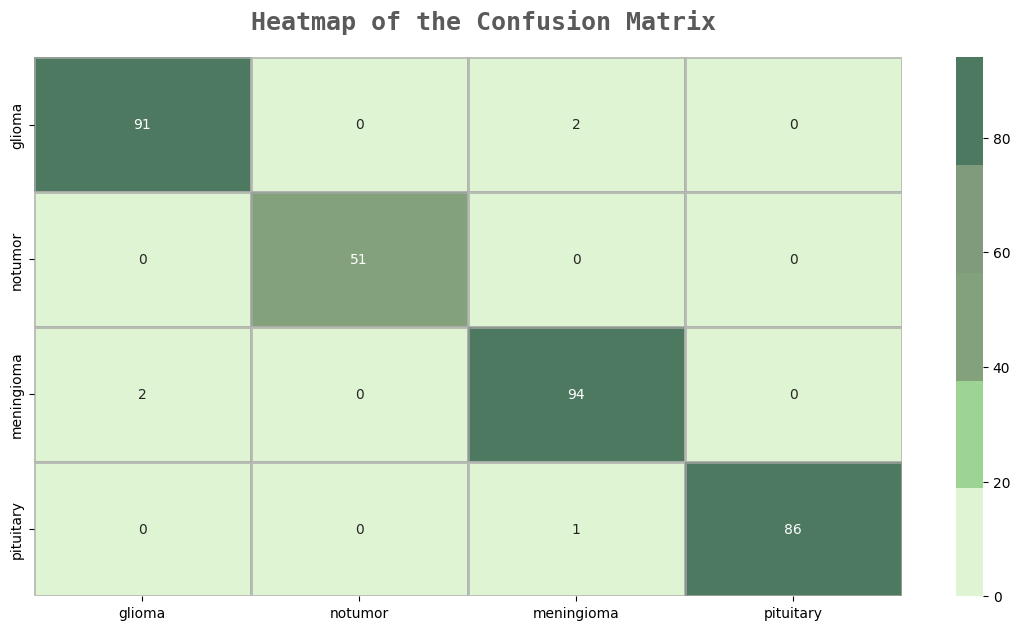

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Trained_Models/effnet.keras')

In [ ]:
X_test.shape


(327, 150, 150, 3)

In [ ]:
X_new=X_test[1].reshape(1,150,150,3)

In [ ]:
X_new.shape

(1, 150, 150, 3)

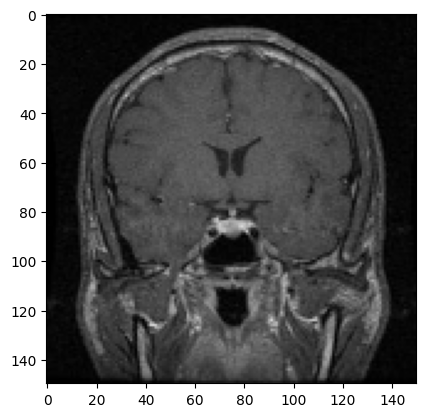

In [ ]:
plt.imshow(X_test[0])

In [ ]:
new_pred=new_model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


In [ ]:
np.argmax(new_pred,axis=1)

array([2])